In [16]:
%reload_ext autoreload
%autoreload 2

# Imports & Utility Functions

In [1]:
import base64
import functools
import os
import pickle
import ssl
import re
import tempfile

from urllib import request

import cv2
import imageio
import numpy as np
import scipy.io.wavfile

from IPython.display import HTML

### Utils

In [2]:
def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=25)
    with open('./animation.gif', 'rb') as f:
        gif_64 = base64.b64encode(f.read()).decode('utf-8')
    return HTML('<img src="data:image/gif;base64,%s"/>' % gif_64)

def play_audio(data, sample_rate=48000):
    scipy.io.wavfile.write('tmp_audio.wav', sample_rate, data)

    with open('./tmp_audio.wav', 'rb') as f:
        audio_64 = base64.b64encode(f.read()).decode('utf-8')
    return HTML('<audio controls src="data:audio/wav;base64,%s"/>' % audio_64)

def table(elements):
    row = ['<td>%s</td>' % el.data for el in elements]
    return HTML('<table><tr>%s</tr></table>' % ''.join(row))

In [4]:
import h5py
import numpy as np

hf = h5py.File("y_train.h5", "r")
data = hf.get("data")

In [74]:
np.array(data)

array([-0.5, -1.2,  1.8, ...,  0.6, -0.4,  2. ])

In [17]:
import pickle

# pickle.load("mosi_data.pkl")
with open("mosi_data.pkl", 'rb') as pickle_file:
    content = pickle.load(pickle_file)

In [24]:
content["train"].keys()

dict_keys(['vision', 'labels', 'text', 'audio', 'id'])

In [32]:
content["train"]["vision"].shape

(1284, 50, 20)

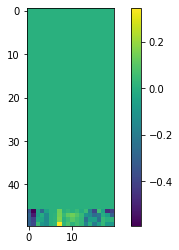

In [42]:
import matplotlib.pyplot as plt

plt.imshow(content["train"]["vision"][570,: ,:])
plt.colorbar()
plt.show()

In [78]:
content["train"]["labels"].shape

(1284, 1, 1)

csd

In [96]:
h = h5py.File("CMU_MOSI_Opinion_Labels.csd", "r")
np.array(h.get("Opinion Segment Labels").get("data").get("03bSnISJMiM").get("features"))
# np.array(h.get("Opinion Segment Labels").get("metadata"))

array([[ 2.4 ],
       [-0.8 ],
       [-1.  ],
       [-1.75],
       [ 0.  ],
       [ 0.  ],
       [ 0.8 ],
       [ 0.  ],
       [ 0.2 ],
       [-1.2 ],
       [-0.5 ],
       [ 2.2 ],
       [ 1.8 ]], dtype=float32)

In [95]:
# get a full array from h
np.array(h.get("Opinion Segment Labels").get("data").get("03bSnISJMiM").get("intervals"))

array([[ 51.904533,  55.94535 ],
       [ 56.045124,  66.78072 ],
       [ 66.78072 ,  68.73628 ],
       [ 68.73628 ,  70.542175],
       [ 70.542175,  71.69955 ],
       [ 71.69955 ,  72.85692 ],
       [ 72.85692 ,  77.79569 ],
       [ 77.79569 ,  89.52902 ],
       [ 89.52902 ,  92.23288 ],
       [ 92.23288 ,  94.80703 ],
       [ 94.80703 ,  96.57301 ],
       [ 96.57301 ,  99.01746 ],
       [168.65918 , 170.24557 ]], dtype=float32)

# Real

In [100]:
import os
import h5py	
import numpy as np

DATA_PATH = '../../data/CMU_MOSI/'
VIDEO_PATH = os.path.join(DATA_PATH, 'Video/Segmented')
LABELS_PATH = os.path.join(DATA_PATH, 'CMU_MOSI_Opinion_Labels.csd')

In [130]:
labels_csd = h5py.File(LABELS_PATH, 'r').get("Opinion Segment Labels")

In [131]:
labels_csd.keys()

<KeysViewHDF5 ['data', 'metadata']>

In [143]:
f = list(labels_csd["data"].get("03bSnISJMiM").get("features"))
f

[array([2.4], dtype=float32),
 array([-0.8], dtype=float32),
 array([-1.], dtype=float32),
 array([-1.75], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.8], dtype=float32),
 array([0.], dtype=float32),
 array([0.2], dtype=float32),
 array([-1.2], dtype=float32),
 array([-0.5], dtype=float32),
 array([2.2], dtype=float32),
 array([1.8], dtype=float32)]

In [162]:
list(np.array(labels_csd["data"].get("03bSnISJMiM").get("features"))[:,0])

[2.4, -0.8, -1.0, -1.75, 0.0, 0.0, 0.8, 0.0, 0.2, -1.2, -0.5, 2.2, 1.8]

# Test dataset 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
path = %pwd
if path.split(os.sep)[-1] == 'Perceiver':
    %cd ../..

/mnt/c/Users/Mustapha/Documents/CENTRALESUPELEC_3A/advanced AI/multimodal_sentiment_analysis


In [3]:
import numpy as np
from src.data_loaders.cmu_mosi import get_train_val

In [4]:
train_loader, val_loader = get_train_val(batch_size=1, debugging=True)

Caching videos for validation split: 100%|██████████| 10/10 [00:00<00:00, 11.03it/s]


In [5]:
len(val_loader)

3

In [6]:
len(train_loader)

10

In [7]:
data = train_loader.dataset

In [8]:
data[11][1]

array([-0.00205994, -0.0025177 , -0.00073242, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [9]:
data[7][1].shape

(38058,)

# Perceiver

In [10]:
from transformers import PerceiverForMultimodalAutoencoding
from tqdm.notebook import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PerceiverForMultimodalAutoencoding.from_pretrained("deepmind/multimodal-perceiver")
# model.to(device)

In [24]:
# model = PerceiverForMultimodalAutoencoding.from_pretrained("deepmind/multimodal-perceiver")

# image = torch.rand(1, 16, 224, 224) # Not good
image = torch.rand(1, 16, 3, 224, 224)
audio =  torch.rand(1, 30720, 1)

inputs = dict(
    image = image,
    audio =  audio,
    label =  torch.zeros((1, 700))
)

nchunks = 128
image_chunk_size = np.prod((16, 224, 224)) // nchunks
audio_chunk_size = audio.shape[1] // model.config.samples_per_patch // nchunks

chunk_idx = 127
subsampling = {
    "image": torch.arange(image_chunk_size * chunk_idx, image_chunk_size * (chunk_idx + 1)),
    "audio": torch.arange(audio_chunk_size * chunk_idx, audio_chunk_size * (chunk_idx + 1)),
    "label": None,
}

In [25]:
model.config.samples_per_patch

16

In [26]:
output = model(inputs = inputs , subsampled_output_points=subsampling)

In [27]:
out_label = output.logits["label"]

In [28]:
torch.topk(out_label, 5).indices

tensor([[663,  49, 199, 637, 574]])

In [30]:
torch.topk(out_label, 5).indices

tensor([[278, 663,  67, 354, 647]])